# **1. Importing Libraries**

In this Notebook we will use a Pre Trained Model like Resnet50 for Classification of Dog Breed.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 

import tensorflow as tf
tf.config.run_functions_eagerly(True)
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, InputLayer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings("ignore") 

plt.rcParams['font.size'] = 10

# **2. Fetching Data** 

### We will use Image_dataset_from_directory to ffetch the data and perform some data augmentations

In [2]:
fpath = "/kaggle/input/stanford-dogs-dataset/images/Images"
random_seed = 42

In [3]:
img_size = 224
batch_size =32
train = tf.keras.utils.image_dataset_from_directory(
  fpath,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_size, img_size),
  batch_size=batch_size,
  label_mode ="categorical"
)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.


In [4]:
val = tf.keras.utils.image_dataset_from_directory(
  fpath,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_size, img_size),
  batch_size=batch_size,
  label_mode ="categorical"
)

Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


# **3. Plotting Data** 

In [5]:
class_names = train.class_names

In [6]:
names=[]
for name in class_names :
    names.append(name.split("-")[1]) 
    
print(names[:10]) # Printing some species

['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound']


### Visualizing some images of different Classes

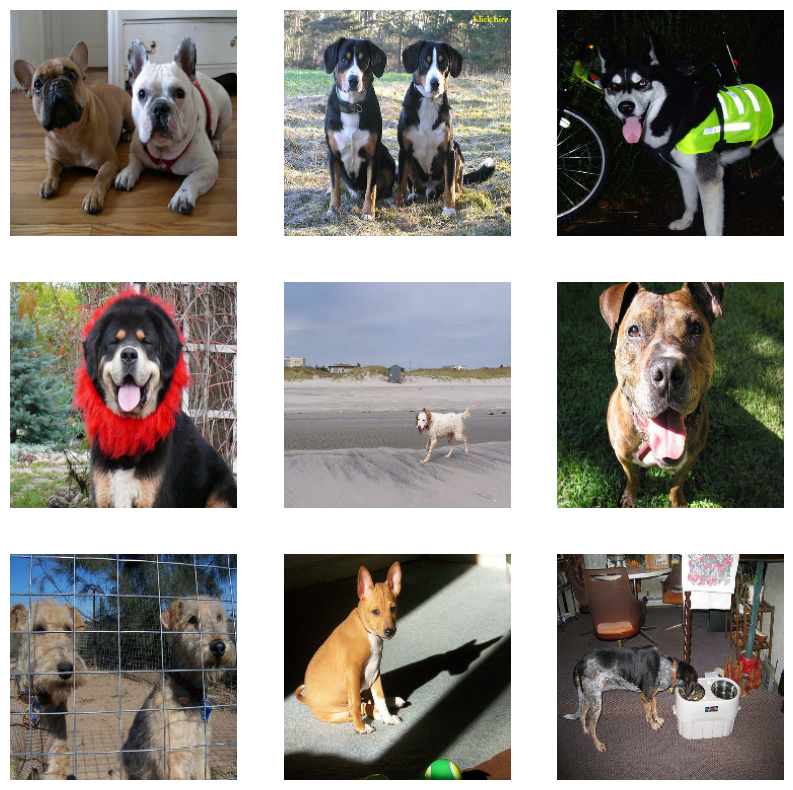

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")


# **4. Building a Model (Resnet50)** 

### We are calling Resnet50 and adding some layers of our own

### Below is the Architecture of Resnet50 
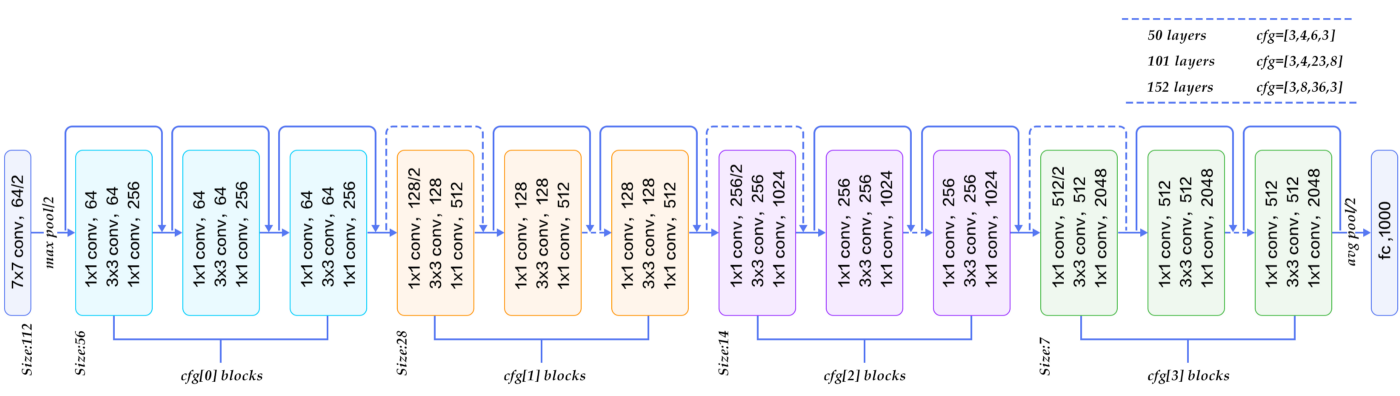

In [8]:
Model_URL ='https://kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/50-classification/versions/2'
model = Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(img_size, img_size, 3)),
    hub.KerasLayer(Model_URL),
    tf.keras.layers.Dense(120, activation="softmax")])

### Compiling the model in which we are using Categorical Crossentropy and the optimizer is Adam.

In [9]:
model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"] 
  )

In [10]:
model.build((img_size, img_size, 3))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1001)              25615849  
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 25,736,089
Trainable params: 120,240
Non-trainable params: 25,615,849
_________________________________________________________________


### We will add 3 Very Important Callbacks for our model 
* ModelCheckpoint: This callback saves the model weights after every epoch if the validation loss improves.
* EarlyStopping: This callback stops the training process if the validation loss doesn't improve for a certain number of epochs.
* ReduceLROnPlateu: This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

All of them prevent Overfitting and save the best model according to the validation loss.


In [12]:
model_name = "model.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

 

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5,
                                                 verbose = 1, restore_best_weights=True)

reduce_lr = tf._keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [13]:
history = model.fit(train, epochs=11, validation_data=val, callbacks=[checkpoint,earlystopping, reduce_lr])

Epoch 1/11
515/515 [==============================] - ETA: 0s - loss: 1.4841 - accuracy: 0.6275
Epoch 1: val_loss improved from inf to 1.09187, saving model to model.h5
515/515 [==============================] - 4078s 8s/step - loss: 1.4841 - accuracy: 0.6275 - val_loss: 1.0919 - val_accuracy: 0.7038 - lr: 0.0010
Epoch 2/11
515/515 [==============================] - ETA: 0s - loss: 0.7625 - accuracy: 0.7807
Epoch 2: val_loss did not improve from 1.09187
515/515 [==============================] - 4071s 8s/step - loss: 0.7625 - accuracy: 0.7807 - val_loss: 1.1004 - val_accuracy: 0.7165 - lr: 0.0010
Epoch 3/11
515/515 [==============================] - ETA: 0s - loss: 0.5544 - accuracy: 0.8304
Epoch 3: val_loss did not improve from 1.09187
515/515 [==============================] - 4167s 8s/step - loss: 0.5544 - accuracy: 0.8304 - val_loss: 1.1270 - val_accuracy: 0.7194 - lr: 0.0010
Epoch 4/11
515/515 [==============================] - ETA: 0s - loss: 0.4334 - accuracy: 0.8656
Epoch 4: va

# **5. Visualizing The Loss & Accuracy Curves**

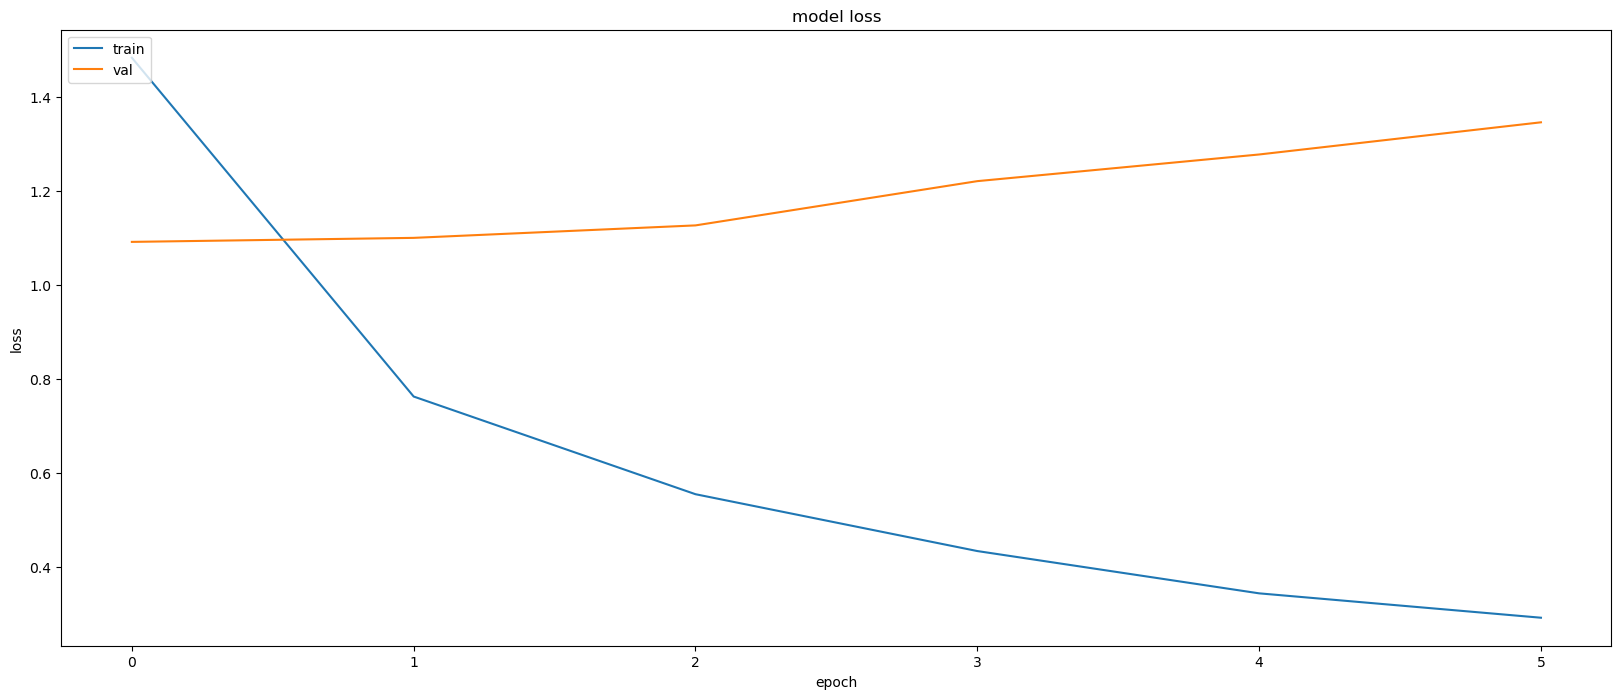

In [14]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

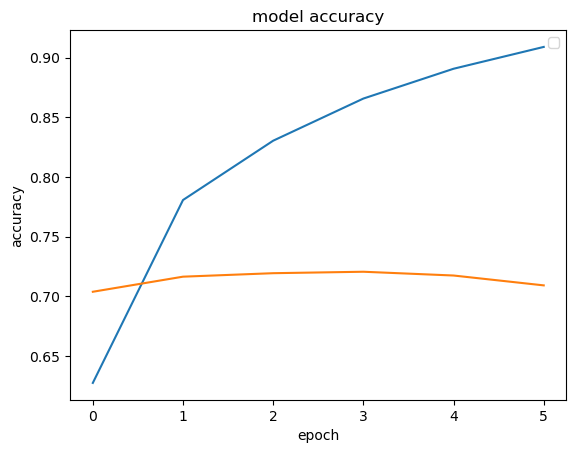

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

# **6. Prediction & Accuracy**

In [16]:
loss, accuracy = model.evaluate(val)

129/129 [==============================] - 219s 2s/step - loss: 1.0919 - accuracy: 0.7038


In [17]:
print(f"Accuracy is: {round(accuracy*100,2)}%")

Accuracy is: 70.38%


Thank you for checking out my notebook and do let me know if there are any suggestions.